### Tests

First tests of dbscans on a list of OCs

In [1]:
import sys, os
sys.path.append('../../src')

import astropy.coordinates as coord

from astropy.io.votable import parse
from astropy.table import Table
from astropy import units as u

import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from math import ceil , pi , cos, sin
import gaia_utils as gu
from sklearn.cluster import KMeans

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/gaia-shock/notebooks/data"%(rootdir)

os.chdir(wdir)

#### Input Parameters########################################################
filelist = datadir+"/"+"BrowseTargets.18292.1530479692.gaia.selected.txt"
fileoutGaia = wdir + "/"+"BrowseTargets.18292.1530479692.gaia.dbscan.txt"

WEIGHT = [6.76, 6.76, 12.45, 4.1, 4.1, 2.77, 2.77, 2.77]

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
from astroquery.gaia import Gaia

# tables = Gaia.load_tables(only_names=True)

#for table in (tables):
#    print (table.get_qualified_name())
    

In [3]:
## read the cluster list from HEASARC
def read_cluster_list(filelist):
    
    df = pd.read_csv(filelist, sep='|')
    
    return(df)

######
def init_SCgaia(filegaia, filelist):
    "init output if not there.."
    
    if not os.path.exists(filegaia):
        with open(filelist,"r") as f:
            header = f.readline()
        with open(filegaia,"w") as f:
            f.write(header)
    
#######
## write in fileoutGaia the selected cluster for GAIA
def write_SCgaia(filegaia, row):
    df = pd.DataFrame(row).T
    df.to_csv(filegaia,sep ="|", mode = "a", header= False, index = False)
    
    
######       
## find the last SC found.
def find_lastSC(filegaia,filelist, dfsc):
    if os.path.exists(filegaia):
        print(filegaia)
        dfcurrent = read_cluster_list(filegaia)
        last_cluster = dfcurrent['name'].iloc[[-1]].iloc[0]
        index = dfsc.index[dfsc['name'].str.contains(last_cluster)]
    else:
        init_SCgaia(filegaia, filelist)
        last_cluster = "No cluster"
        index = [0]
        
    return(last_cluster, index[0])

In [4]:
## plot results dbscans..

def plot2d(df, distsc,result, labels, ilab, cmap = "gist_stern" , figname = "test.dbscan.png", color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 1.0, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 1.0, c = "k")
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=1.0, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 1.0, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 1.0, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-0.5,2.0)
    axarr[1,1].set_ylim(27.,10)
    
    ### properties
    nstars    = result['nstars'][ilab+1]
    posl      = result['pos'][ilab+1][0]
    posb      = result['pos'][ilab+1][1]
    dist      = result['distance'][ilab+1]
    velra     = result['vel'][ilab+1][0]
    veldec    = result['vel'][ilab+1][1]
    stdl      = result['pos_std'][ilab+1][0]
    stdb      =  result['pos_std'][ilab+1][1]
    stdist    =  result['distance_std'][ilab+1]
    stdvelra  = result['vel_std'][ilab+1][0] 
    stdveldec = result['vel_std'][ilab+1][1]
    
    txt = "Obs. dist: %3.1f pc"%(distsc)
    axarr[1,1].text(0.05, 0.05, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "N: %d"%(nstars)
    axarr[1,1].text(0.05, 0.10, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Dist: %3.1f (%3.1f)"%(dist,stdist)
    axarr[1,1].text(0.05, 0.15, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "l,b: %3.1f , %3.1f"%(posl,posb)
    axarr[1,1].text(0.05, 0.2, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Disp l,b: %3.1f , %3.1f"%(stdl,stdb)
    axarr[1,1].text(0.05, 0.25, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Vel: %3.1f , %3.1f"%(velra, veldec)
    axarr[1,1].text(0.05, 0.3, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Disp Vel: %3.1f , %3.1f"%(stdvelra, stdveldec)
    axarr[1,1].text(0.05, 0.35, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Ell.: %3.1f , %3.1f"%(stdl / stdb, stdvelra / stdveldec)
    axarr[1,1].text(0.05, 0.4, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    
    
    plt.savefig(figname)
    
    plt.show()
  

def print_result(result, ilab):
    "print best result..."
    
    nstars    = result['nstars'][ilab+1]
    posl      = result['pos'][ilab+1][0]
    posb      = result['pos'][ilab+1][1]
    dist      = result['distance'][ilab+1]
    velra     = result['vel'][ilab+1][0]
    veldec    = result['vel'][ilab+1][1]
    stdl      = result['pos_std'][ilab+1][0]
    stdb      =  result['pos_std'][ilab+1][1]
    stdist    =  result['distance_std'][ilab+1]
    stdvelra  = result['vel_std'][ilab+1][0] 
    stdveldec = result['vel_std'][ilab+1][1]
    
    print("## Physical properties of the label %d"%(ilab))
    print("## N stars: %d"%(nstars))
    print("## Pos. mean (l,b): %4.2f , %4.2f"%(posl, posb))
    print("## Disp. (l,b): %4.2f , %4.2f"%(stdl, stdb))
    print("##")
    print("## Distance mean (pc): %4.2f"%(dist))
    print("## Disp. (distance): %4.2f"%(stdist))
    print("##")
    print("## Vel. mean (RA,Dec): %4.2f , %4.2f"%(velra, veldec))
    print("## Vel. disp. (RA,Dec): %4.2f , %4.2f"%(stdvelra, stdveldec))
    print("##")
    print("## Ellipticities:")
    print("## Spatial (l/b) : %4.2f"%(stdl / stdb))
    print("## Vel. (RA/Dec) : %4.2f"%(stdvelra / stdveldec))   

In [ ]:
def average_density_hyperspace(df):
    "compute the average density and distance"
    
    
    ndim = df.shape
    nstars = ndim[0]
    nbootstrap = 3000
    
    npts = df[np.random.randint(0,nstars, nbootstrap),:]
    dist = pdist(npts)
    distmin = np.min(dist[np.nonzero(dist)])
    distmean = np.mean(dist[np.nonzero(dist)])
    distmax = np.max(dist[np.nonzero(dist)])
    
    return(distmin, distmean, distmax)    

In [5]:
-

In [ ]:
def iter_dbscan(s, epsmin, epsmax, sample_min, sample_max, neps = 20, aper = 0.5, 
                qmin = 7., MAX_NSTAR = True, von = "test.vot", verbose = True, rhomin = 0.):
    "Range of the parameters for dbscan. The selection can be done either on Q or nstar and Q..."
        
        
    if MAX_NSTAR:
        print("## DBSCAN selection of the clusters with  Q > %f and the maximum of stars."%(qmin))
    else:
        print("## DBSCAN selection of the clusters with  Q maximum regardless of the number of stars.")
        
    if rhomin > 0.:
        print("## DBSCAN is performed only if rho = min_samples / eps > %f"%(rhomin))
      
    print("## Aperture for metric: %3.2f"%(aper))
    
    # s = gu.source(clustername)
    # s.read_votable(von)
    # s.weight = WEIGHT
    # s.convert_filter_data(mag_range = mag_range)
    # s.normalization_normal()

    metric = {}

    epsilon    = np.linspace(epsmin,epsmax, neps)
    sample_min = np.arange(sample_min, sample_max)
    
    metric['eps'] = []
    metric['min_samples'] = []
    metric['Q'] = []
             
    qmax = 0.
    nstar_max = 0
    cluster_best = {}
    result_best = {}
    label_best = []
    ilab_best = []
    
    epsilon_best = 0
    min_sample_best = 0
    ilab_best = -1
    
    for e in epsilon:
        print('.' , end="")
        for sm in sample_min:
                
                if sm / e > rhomin:
                    labels_d, result = s.dbscan_(e, sm)
                    n_clusters_ = len(result['label']) -1
                else:
                    n_clusters_ = 0
                
                if n_clusters_ > 0:
                    for nstar, lab in zip(result['nstars'], result['label']):
                        
                        if lab > -1:
                            Q, Q_err = metric2_label(s.df, labels_d, lab,  APERTURE = aper , MAXRADIUS = 0.9 * RADIUS , NBOOTSTRAP =50 )
                        else:
                            Q, Q_err = 0. , 0.
                            
                        ## SELECTION .... ########################
                        if MAX_NSTAR:
                            if Q > qmin and nstar > nstar_max:
                                cluster_best = result
                                label_best = labels_d
                                ilab_best = lab
                                result_best = result
                                epsilon_best = e
                                min_sample_best = sm
                                qmax = Q
                                nstar_max = nstar
                        else:
                            if Q > qmax:
                                cluster_best = result
                                label_best = labels_d
                                ilab_best = lab
                                result_best = result
                                epsilon_best = e
                                min_sample_best = sm
                                qmax = Q
                                nstar_max = nstar        
                    
                    if verbose:
                        print("##")
                        print("Epsilon: %3.2f - Min Sample: %d"%(e,sm))
                        for i in range(max(labels_d)+1):
                            print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
                            print("##")
                else:
                    metric['Q'].append(0.)
                    metric['eps'].append(e)
                    metric['min_samples'].append(sm)
                            
    print("\n## DBSCAN done!") 
    print("## Eps: %f - min sample: %d"%(epsilon_best, min_sample_best))
    print("## Q max: %f"%(qmax))
    # print(cluster_best)
    
    return(label_best, ilab_best, cluster_best, result_best, epsilon_best, min_sample_best)

RangeIndex(start=0, stop=339, step=1)
Index(['Unnamed: 0', 'name', 'ra', 'dec', 'cluster_radius', 'rad_vel',
       'rad_vel_error', 'num_cluster_stars', 'distance', 'log_age',
       'log_age_error', 'Unnamed: 11'],
      dtype='object')
/home/stephane/Science/GAIA/products/BrowseTargets.18292.1530479692.gaia.dbscan.txt
FSR 1607         
#####################
## Cluster: FSR 1607
## Distance: 1561.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',173.2500000000,-77.8250000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',173.250000000

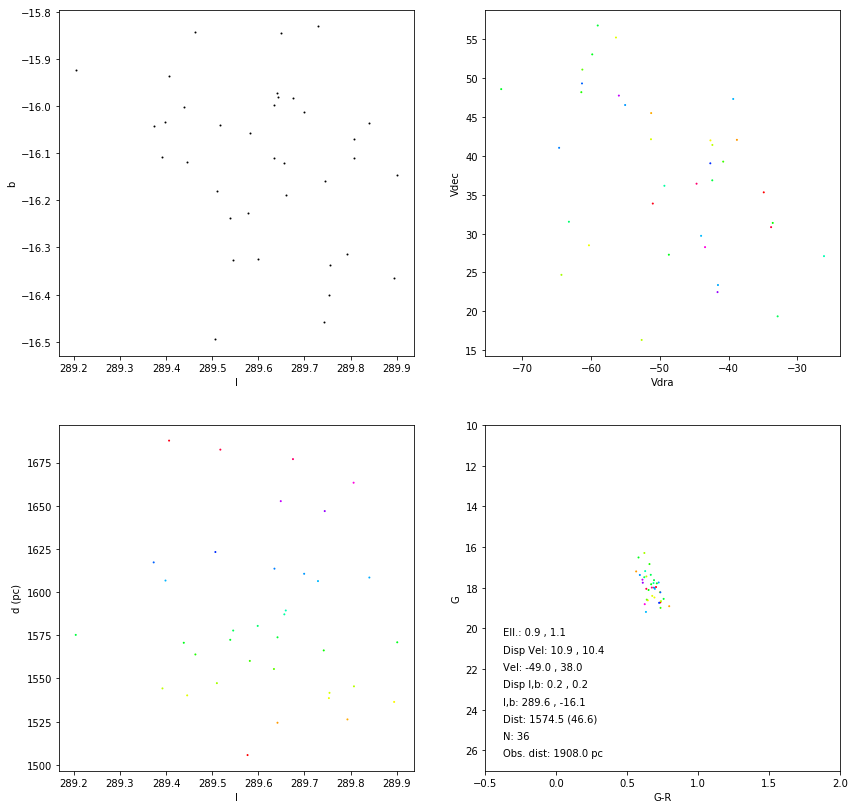

#####################
## Cluster: FSR 1566
## Distance: 1537.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',147.6458333333,-72.7616666667,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',147.6458333333,-72.7616666667,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## FSR 1566-2.0deg.vot created
## Query for FSR 1566 done
## Total stars: 82615
## Conversion done...
## Stars selected: 55911
## Normalization Norm

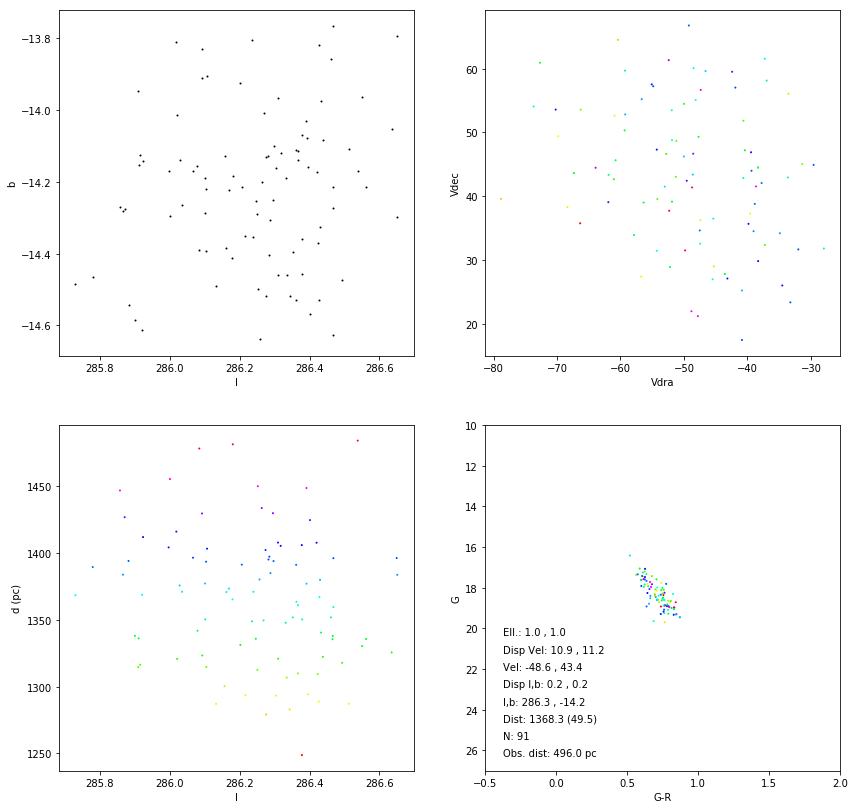

#####################
## Cluster: MWSC 4483
## Distance: 1397.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',289.2833333333,-68.5250000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',289.2833333333,-68.5250000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 4483-2.0deg.vot created
## Query for MWSC 4483 done
## Total stars: 42850
## Conversion done...
## Stars selected: 33897
## Normalization N

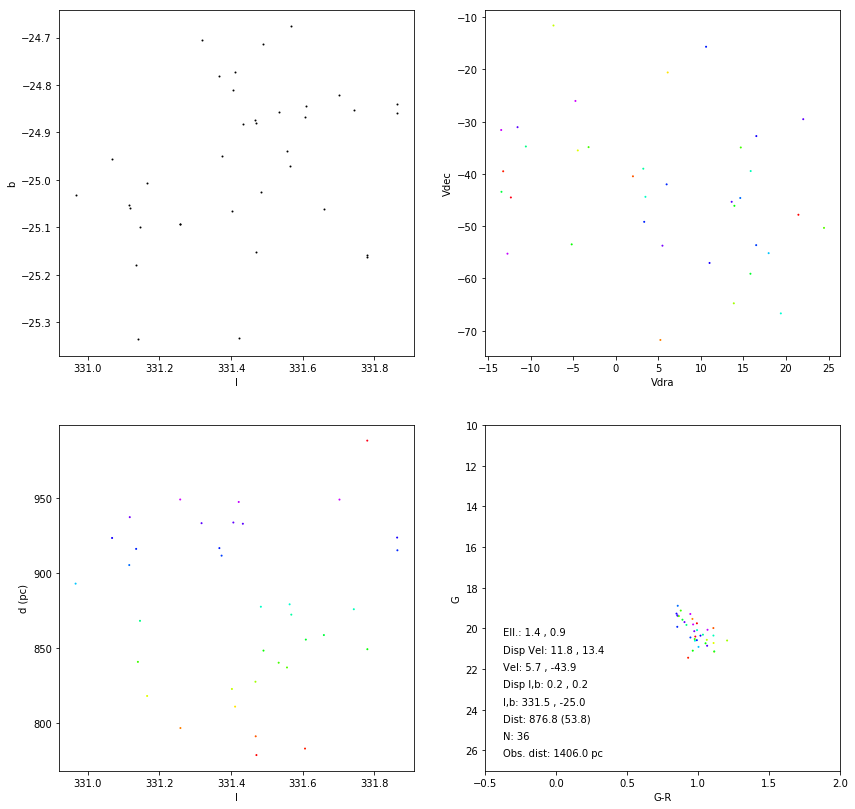

#####################
## Cluster: MWSC 5697
## Distance: 1496.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',276.1500000000,-62.1950000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',276.1500000000,-62.1950000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 5697-2.0deg.vot created
## Query for MWSC 5697 done
## Total stars: 55771
## Conversion done...
## Stars selected: 44026
## Normalization N

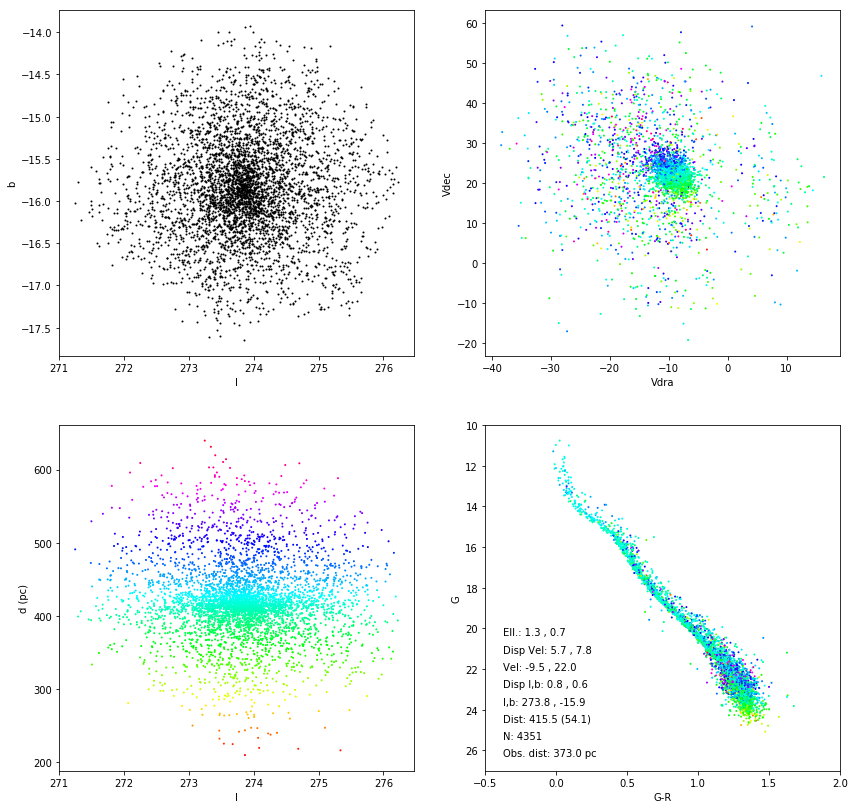

#####################
## Cluster: ESO 123-26
## Distance: 816.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',118.0500000000,-60.3400000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',118.0500000000,-60.3400000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## ESO 123-26-2.0deg.vot created
## Query for ESO 123-26 done
## Total stars: 61599
## Conversion done...
## Stars selected: 45769
## Normalization

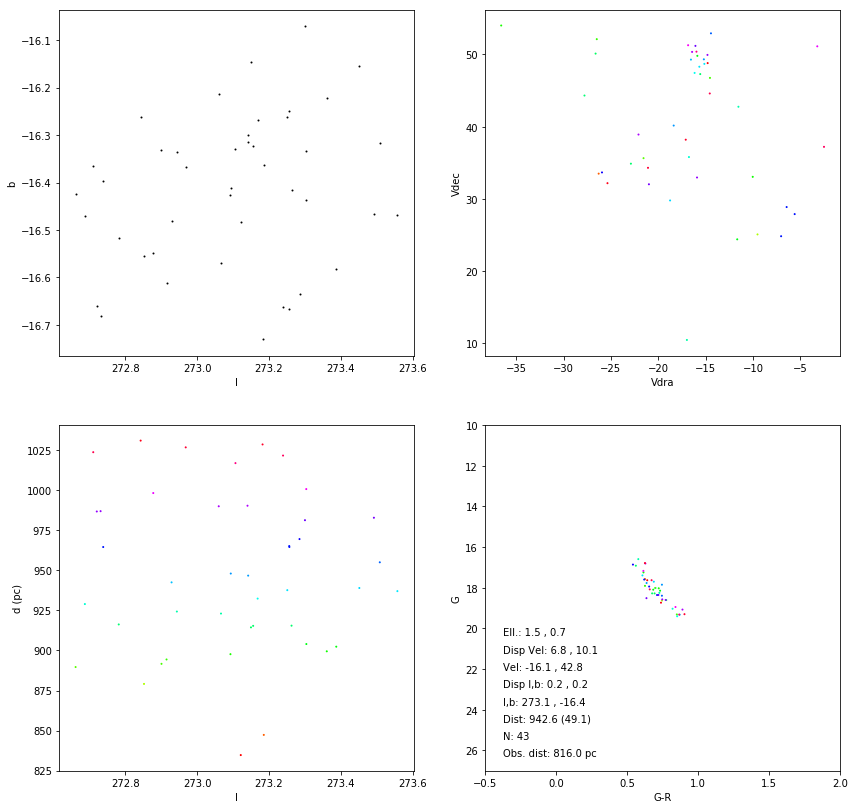

#####################
## Cluster: MWSC 4116
## Distance: 1743.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',94.8000000000,-59.9700000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',94.8000000000,-59.9700000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 4116-2.0deg.vot created
## Query for MWSC 4116 done
## Total stars: 30728
## Conversion done...
## Stars selected: 24889
## Normalization Nor

In [ ]:
###############################################################
######  Main loop
###############################################################

df_cluster = read_cluster_list(filelist)
print(df_cluster.index)
print(df_cluster.columns)

lastSC , lastrow = find_lastSC(fileoutGaia, filelist, df_cluster)

print(lastSC)

for index, row in df_cluster.iloc[lastrow:].iterrows():
    print("#####################")
    clustername = row['name'].strip()
    print("## Cluster: %s"%(clustername))
    print("## Distance: %3.1f pc"%(row['distance']))
    
    print("##")
    print("## Starting DBSCAN optimization....")
    print("##")
    
    rasplit = row['ra'].split(' ')
    decsplit = row['dec'].split(' ')
    racluster = "%sh%sm%ss"%(rasplit[0],rasplit[1],rasplit[2])
    deccluster = "%sd%sm"%(decsplit[0],decsplit[1])
    c = coord.SkyCoord(racluster, deccluster, frame='icrs')
    radius = float(row['cluster_radius'])
    RADIUS = max(2.0, radius * 3.5)
    aper = min(0.5, radius * 0.8)
    
    print("## Query radius: %3.1f"%(RADIUS))
    
    source = gu.source(clustername)
    source.weight = WEIGHT
    
    try:
        findCluster = True
        voname = source.query(RADIUS,  coordCluster = [c.ra.deg, c.dec.deg], errtol = 0.2, dump = True)
    # source.read_votable(voname)
    except:
        print("## GAIA query failed...")
        findCluster = False
        
    if findCluster:
        source.convert_filter_data(mag_range = [0., 50])
        source.normalization_normal()
        source.add_cartesian()

        block = [[0,1,2],[3,4],[5,6,7]]
        weightblock = [3.0, 3.0, 2.0]
        source.normalization_PerBlock(block, weightblock, cartesian = False ,norm = "averagestep")
        source.normalization_PerBlock(block, weightblock, cartesian = True , norm = "averagestep", density = True)


        labels_ , ilab_ , cluster_ , result_, eps_, min_sample_  = iter_dbscan(source, 0.5, 5.,  5 , 50, neps = 40, 
                                                              aper = aper, qmin = 3.0, MAX_NSTAR = True, 
                                                              von = voname, verbose = False, rhomin = 10.)
    
        if ilab_ != -1:
            print_result(result_, ilab_)
            figname = "%s-%3.1fdeg.dbscanBest.png"%(clustername,RADIUS)
            plot2d(source.df, row['distance'], result_, labels_ , ilab_, cmap = "hsv" , figname = figname)


    write_SCgaia(fileoutGaia,row)
    
print("## Main loop done...")
